In [19]:
# Import necessary dependencies
import os
import io
import cv2
import glob
import zipfile
import shutil
import random
import scipy.misc
import numpy as np
import pandas as pd
import matplotlib
import keras
import sklearn.metrics
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

# Switch off potential warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [20]:
# Define the hyperparameters
LEARNING_RATE = 0.001
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

url = "https://github.com/adleberg/medical-ai"

# Load image to array
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Download the dataset
print("Downloading...")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(url)))
!git clone {url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Done!")

Downloading...
fatal: destination path 'medical-ai' already exists and is not an empty directory.
Done!


In [21]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head(5)

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


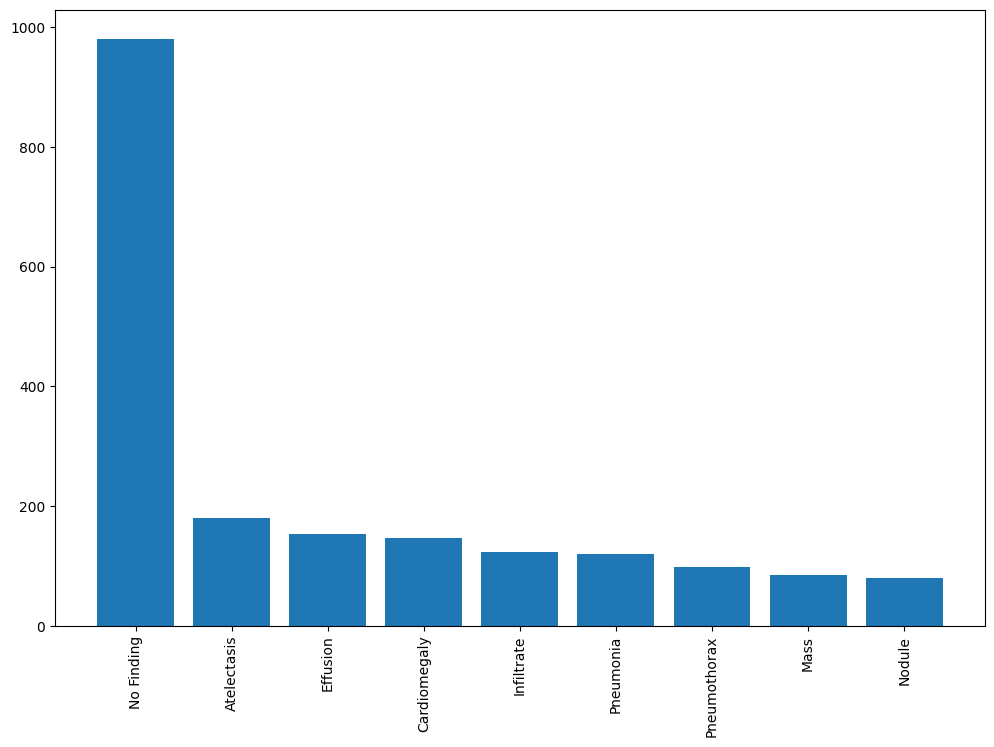

In [22]:
label_counts = df["label"].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [23]:
df["label"].unique() # Check unique labels

array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax', 'No Finding'], dtype=object)

In [24]:
# Seperate to classes
class_names = []

for name in df["label"].unique():
  class_ = name.lower()
  class_ = df.loc[df["label"] == name]
  class_names.append(name)
  print(f"{name}: {len(class_)} examples")

Atelectasis: 180 examples
Cardiomegaly: 146 examples
Effusion: 153 examples
Infiltrate: 123 examples
Mass: 85 examples
Nodule: 79 examples
Pneumonia: 120 examples
Pneumothorax: 98 examples
No Finding: 980 examples


In [26]:
test_ratio = 0.2
root_dir = "/content/medical-ai"
train_dir = "/content/medical-ai/train"
test_dir = "/content/medical-ai/test"

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all images in the root directory
images = [f for f in os.listdir(root_dir+"/images/") if f.endswith(".jpg")]  # Adjust the file extension as needed

# Calculate the number of images for testing based on the test ratio
num_test_images = int(len(images) * test_ratio)

# Randomly shuffle the images
random.shuffle(images)

# Split the images into train and test sets
train_images = images[num_test_images:]
test_images = images[:num_test_images]

# Move images to the train and test directories without class subfolders
for image in train_images:
    src_path = os.path.join(root_dir+"/images/", image)
    dest_path = os.path.join(train_dir, image)
    shutil.move(src_path, dest_path)

for image in test_images:
    src_path = os.path.join(root_dir+"/images/", image)
    dest_path = os.path.join(test_dir, image)
    shutil.move(src_path, dest_path)


In [27]:
# One-hot encode labels
# df = pd.get_dummies(df, columns=['label'], prefix=['label'])

In [28]:
train_path = "/content/medical-ai/train"
test_path = "/content/medical-ai/test"

In [29]:
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)

train_generator = gen.flow_from_dataframe(
    df,
    directory=train_path,
    x_col="filename",
    y_col="label",
    color_mode="rgb",
    target_size=(256, 256),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

validation_generator = gen.flow_from_dataframe(
    df,
    directory=train_path,
    x_col="filename",
    y_col="label",
    color_mode="rgb",
    target_size=(256, 256),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 1575 validated image filenames belonging to 9 classes.
Found 1575 validated image filenames belonging to 9 classes.


In [30]:
x, y = next(train_generator)
x.shape # Input shape of one record

(32, 256, 256, 3)

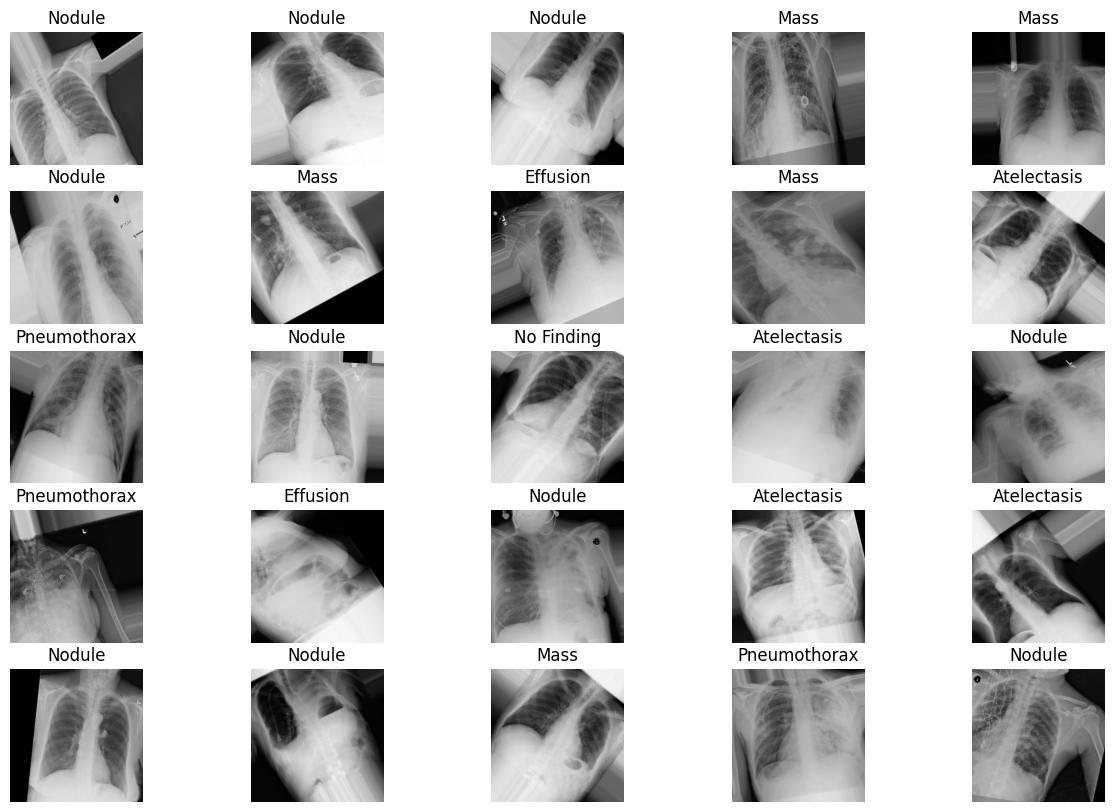

In [31]:
def plot_images(img, labels):
  plt.figure(figsize=(15, 10))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plot_images(x, y)

In [32]:
# Load the InceptionResNetV2 architecture
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Added dropout for regularization
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Added dropout for regularization
    tf.keras.layers.Dense(9, activation='softmax')  # Changed 'sigmoid' to 'softmax' for multiclass
])

In [33]:
# Define custom optimizer
custom_optimizer = Adam(learning_rate=LEARNING_RATE)

In [34]:
model.compile(optimizer=custom_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               786944    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [36]:
early = tf.keras.callbacks.EarlyStopping(patience=10,
                                        min_delta=0.001,
                                        restore_best_weights=True)

In [ ]:
batch_size = 32
# Calculate steps per epoch and validation steps based on data generators
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[early])

Epoch 1/10
25/49 [==============>...............] - ETA: 4:53 - loss: 2.3792 - accuracy: 0.3600

In [ ]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

13/13 [==============================] - 10s 744ms/step - loss: 5.4274 - accuracy: 0.0000e+00
[5.427354335784912, 0.0]
Accuracy: 68.0597%
Loss:  5.427354335784912


1/1 [==============================] - 0s 62ms/step


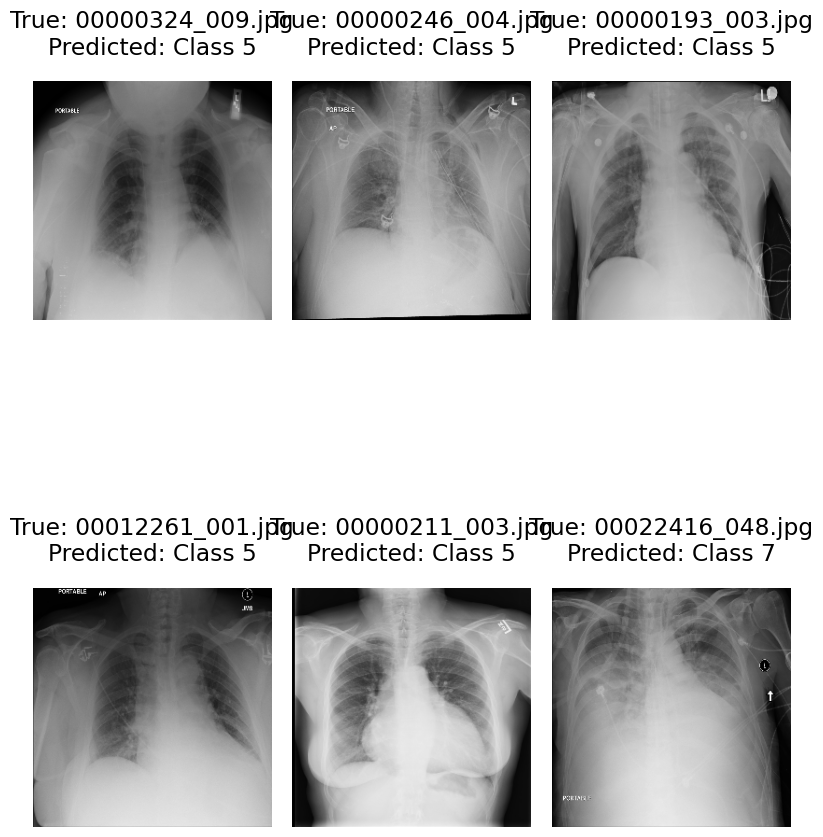

In [ ]:
# Create a subplot to display the images
plt.figure(figsize=(8, 12))

for i, image_filename in enumerate(selected_images, 1):
    # Load the image
    img = tf.keras.preprocessing.image.load_img(os.path.join(test_path, image_filename))

    # Convert the image to a NumPy array
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Resize the image (if needed)
    img = tf.keras.preprocessing.image.smart_resize(img, (256, 256))

    # Reshape the image to match the model's input shape
    img = tf.reshape(img, (-1, 256, 256, 3))

    # Make predictions (assuming 'model' is your trained model)
    prediction = model.predict(img / 255)  # Normalize pixel values
    predicted_class = np.argmax(prediction)

    # Display the image with its true and predicted labels
    plt.subplot(2, 3, i)
    plt.imshow(img[0] / 255)  # Display the image (don't forget to normalize)
    plt.title(f"True: {image_filename}\nPredicted: Class {predicted_class}", pad=20)  # Add padding to the title
    plt.axis('off')

# Show the plot with up to 6 images
plt.tight_layout()
plt.show()

In [ ]:
model.save("xray-classifier.h5")

In [ ]:
!cp /content/medical-ai/xray-classifier.h5 /content/drive/MyDrive/xray-classifier

cp: cannot create regular file '/content/drive/MyDrive/xray-classifier': No such file or directory
